In [1]:
import sys
sys.path.append('/home/etl/Test_Stand/tbanalyisis/') #stupid python
import os
import numpy as np
from utils import plotting as pu
from utils import analysis as au
import awkward as ak
import importlib
import uproot

import matplotlib.pyplot as plt
import hist
import mplhep as hep

In [31]:
#grab new root file with clock to fit

#fast clock data path
fc_data_path = "/home/etl/Test_Stand/ETROC2_Test_Stand/ScopeHandler/ScopeData/LecroyTimingDAQ/run_scope7525.root"

#slow clock data path
sc_data_path = "/home/etl/Test_Stand/ETROC2_Test_Stand/ScopeHandler/ScopeData/LecroyTimingDAQ/run_scope7000.root"


scope_data = uproot.open(sc_data_path)["pulse"]


[25, 24.9, 25, 25, 24.9, 25, 24.9, ..., 24.9, 25, 24.9, 24.9, 24.9, 24.9, 25]
0.007141382937824203


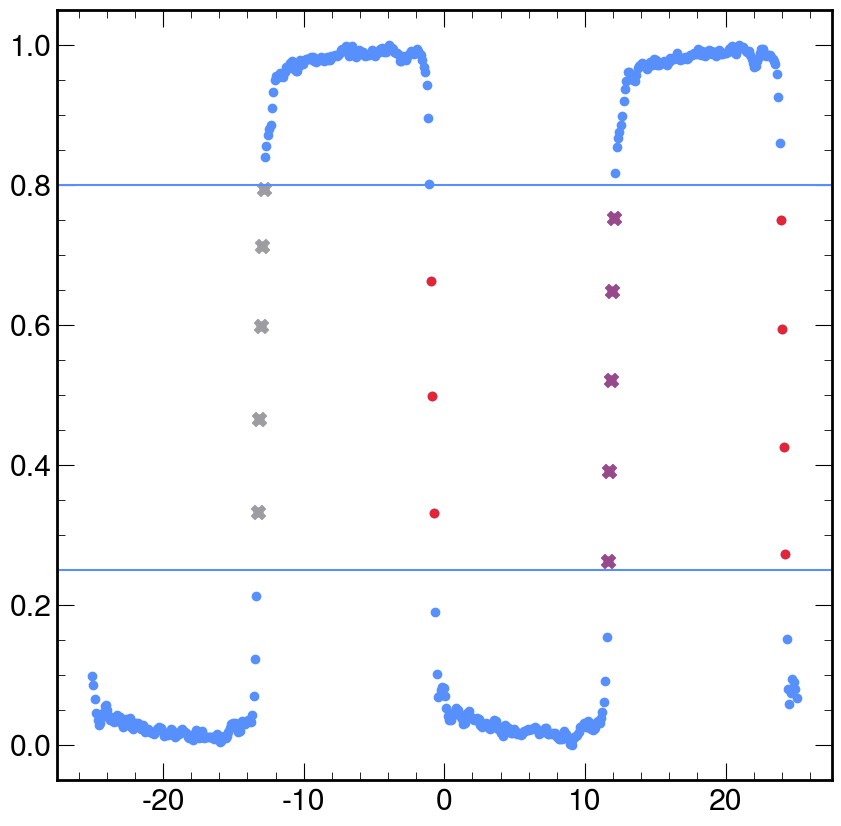

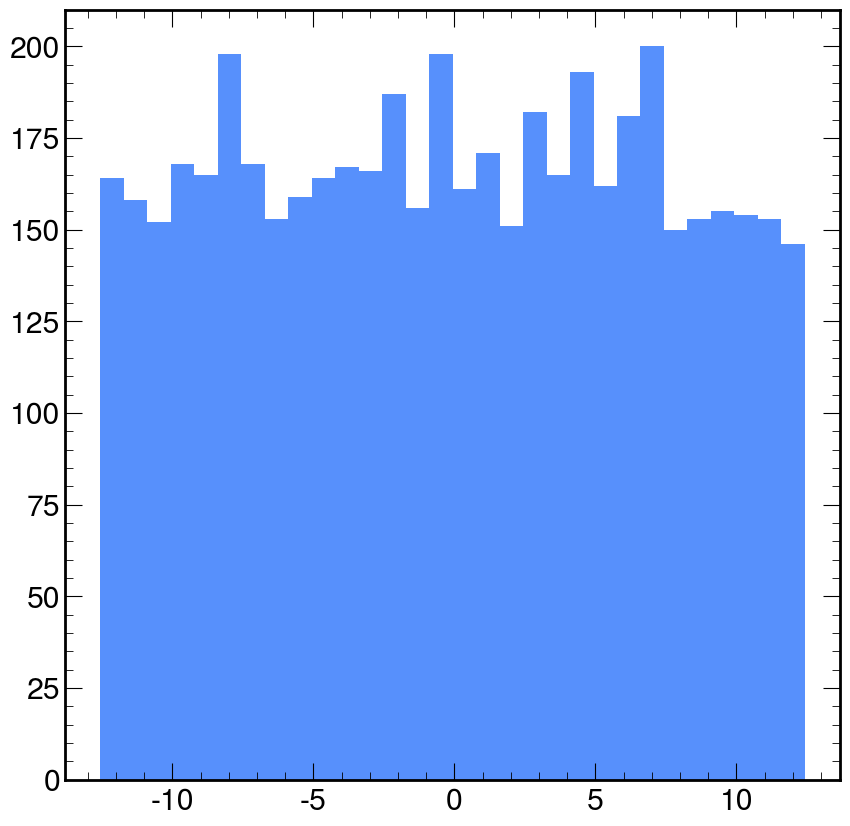

In [33]:

def get_rising_edge_after_first_fall(time, V, thresh_low: int, thresh_high: int):

    def edge_mask(V):
        return ((thresh_low <= V) & (V <= thresh_high))

    def get_idx_between_edgs(edg_idxs):
        #works like np.diff!
        edg_diffs = edg_idxs[:, 1:] - edg_idxs[:, :-1]
        #if there is a diff greater than one in index than we jumped to a new edge!
        return edg_idxs[edg_diffs > 1] + 1
    
    square_wave = ak.zip({
        "t": time,
        'V': V
    })

    ##
    ### GRAB ALL INDICES OF SQUARE WAVE AFTER FIRST FALLING EDGE
    ##
    falling_edg_mask = edge_mask(square_wave.V) & (np.diff(square_wave.V, append=np.inf) < 0)
    sw_idxs = ak.local_index(square_wave)

    #the [...,0] is important, grabs the first index out of each array, 99% of the time there is only one anyway
    falling_transition_idx = get_idx_between_edgs( sw_idxs[falling_edg_mask] )[...,0] 
    past_first_fall = sw_idxs[sw_idxs > falling_transition_idx[:,np.newaxis]]

    # Get Square Wave Past First Fall -> sw_pff
    sw_pff = square_wave[past_first_fall]
    edg_mask = edge_mask(sw_pff.V)

    ##
    ### GET INDICES OF RISING EDGE AFTER FALLING EDGE (from above)
    ##
    sw_pff_idxs = ak.local_index(sw_pff)
    #the [...,0] is important, grabs the first index out of each array, 99% of the time there is only one anyway
    rising_edg_pff = get_idx_between_edgs( sw_pff_idxs[edg_mask] )[...,0]
    rising_after_falling = sw_pff_idxs[sw_pff_idxs < rising_edg_pff[:, np.newaxis]]

    # Apply slice 
    sw_rising_pff = sw_pff[rising_after_falling]
    #need to recut to just get rising edge
    e2mask = edge_mask(sw_rising_pff.V)

    return sw_rising_pff[e2mask].t, sw_rising_pff[e2mask].V


def calc_period(time, V, thresh_low, thresh_high):

    def edge_mask(V):
        return ((thresh_low <= V) & (V <= thresh_high))

    def get_idx_between_edgs(edg_idxs):
        #works like np.diff!
        edg_diffs = edg_idxs[:, 1:] - edg_idxs[:, :-1]
        #if there is a diff greater than one in index than we jumped to a new edge!
        return edg_idxs[edg_diffs > 1] + 1
    
    def get_rising_edg(sw_cut):
        sw_cut_idxs = ak.local_index(sw_cut)
        sw_cut_tdiff = sw_cut.V[:, 1:] - sw_cut.V[:, :-1]
        t_trans = sw_cut_idxs[sw_cut_tdiff > 0] 
        
        rising_and_junk_idxs = sw_cut_idxs[t_trans] #will have full rising edge and other junk
        sw_rising_and_junk = sw_cut[rising_and_junk_idxs]

        clean_edges_idxs = rising_and_junk_idxs[edge_mask(sw_rising_and_junk.V)]   
        sw_clean_edges = sw_rising_and_junk[edge_mask(sw_rising_and_junk.V)]
        return sw_clean_edges, clean_edges_idxs

    square_wave = ak.zip({
        "t": time,
        'V': V
    })

    rising_edg_mask = edge_mask(square_wave.V) & (np.diff(square_wave.V, append=-np.inf) > 0)
    sw_idxs = ak.local_index(square_wave)
    rising_split_idx = get_idx_between_edgs(sw_idxs[rising_edg_mask])[...,0]
    
    before_first_rising_idxs = sw_idxs[sw_idxs <= rising_split_idx[:,np.newaxis]]
    sw_before_first_rising = square_wave[before_first_rising_idxs]
    sw_before_first_rising2 = sw_before_first_rising[edge_mask(sw_before_first_rising.V)]

    after_first_rising_idxs = sw_idxs[sw_idxs >= rising_split_idx[:,np.newaxis]]
    sw_after_rising = square_wave[after_first_rising_idxs]
    sw_after_rising2 = sw_after_rising[edge_mask(sw_after_rising.V)]

    sw_second_rising, ssr2 = get_rising_edg(sw_after_rising)
    drop2_multi_edge = ak.num(get_idx_between_edgs(ssr2)) == 0

    sw_first_rising, sfr1 = get_rising_edg(sw_before_first_rising)
    drop1_multi_edge = ak.num(get_idx_between_edgs(sfr1)) == 0

    sw_second_rising = sw_second_rising[drop2_multi_edge & drop1_multi_edge]
    sw_first_rising = sw_first_rising[drop2_multi_edge & drop1_multi_edge]

    second_fits = ak.linear_fit(sw_second_rising.t, sw_second_rising.V, axis=-1)
    second_clocks = (0.5 - second_fits['intercept'])/second_fits['slope']
    first_fits = ak.linear_fit(sw_first_rising.t, sw_first_rising.V, axis=-1)
    first_clocks = (0.5 - first_fits['intercept'])/first_fits['slope']

    # print(second_clocks)
    # print(first_clocks)

    fig, ax = plt.subplots()
    plot_idx = 3

    square_wave = square_wave[drop2_multi_edge & drop1_multi_edge]
    sw_before_first_rising2 = sw_before_first_rising2[drop2_multi_edge & drop1_multi_edge]
    sw_after_rising2 = sw_after_rising2[drop2_multi_edge & drop1_multi_edge]
    
    ax.scatter(square_wave.t[plot_idx], square_wave.V[plot_idx])
    ax.scatter(sw_before_first_rising2.t[plot_idx], sw_before_first_rising2.V[plot_idx], label='before rising')
    ax.scatter(sw_after_rising2.t[plot_idx], sw_after_rising2.V[plot_idx], label='after rising')

    s = 0
    ax.scatter(sw_second_rising.t[plot_idx+s], sw_second_rising.V[plot_idx+s], label='second rising ', marker='X', s=100)
    ax.scatter(sw_first_rising.t[plot_idx+s], sw_first_rising.V[plot_idx+s], label='first rising ', marker='X', s=100)

    plt.axhline(thresh_low)
    plt.axhline(thresh_high)

    return second_clocks - first_clocks

time = scope_data['time'].array()
#time is for some reason 
channels = scope_data['channel'].array()
clock = channels[:,2]

#grab first time, time is pecularly shaped, 5000 * 1 * 1002, so we make it now 5000 * 1002
time = time[:,0]*10**9

#SCALE the clock so values are between 0 and 1
clk_mins = ak.min(clock, axis=1, keepdims=True)
clk_maxs = ak.max(clock, axis=1, keepdims=True)
clock = (clock - clk_mins) / (clk_maxs-clk_mins)

thresh_low, thresh_high = 0.25, 0.8

rtime, rclock = get_rising_edge_after_first_fall(time, clock, thresh_low, thresh_high)
fits = ak.linear_fit(rtime, rclock, axis=-1)

Clocks = (0.5 - fits['intercept'])/fits['slope']


Ts = calc_period(time, clock, thresh_low, thresh_high)
print(Ts)
print(np.std(Ts))

fig, ax = plt.subplots()
ax.hist(Clocks, bins=30)
# print('done')

plot_idx = 481 #422

# for plot_idx in range(100):
# fig, ax = plt.subplots()
# t_tot, c_tot = time[plot_idx], clock[plot_idx]
# rt, rc = rtime[plot_idx], rclock[plot_idx]
# m, b = fits['slope'][plot_idx], fits['intercept'][plot_idx]
# ax.scatter(t_tot, c_tot)
# ax.scatter(rt, rc)
# ax.plot(rt, m*rt + b)

# plt.axhline(0.5)
# plt.axhline(thresh_low)
# plt.axhline(thresh_high)
# fig.savefig(f'ok_{plot_idx}.png')


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f82f01fc1d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f82e7f57260>, text=[])

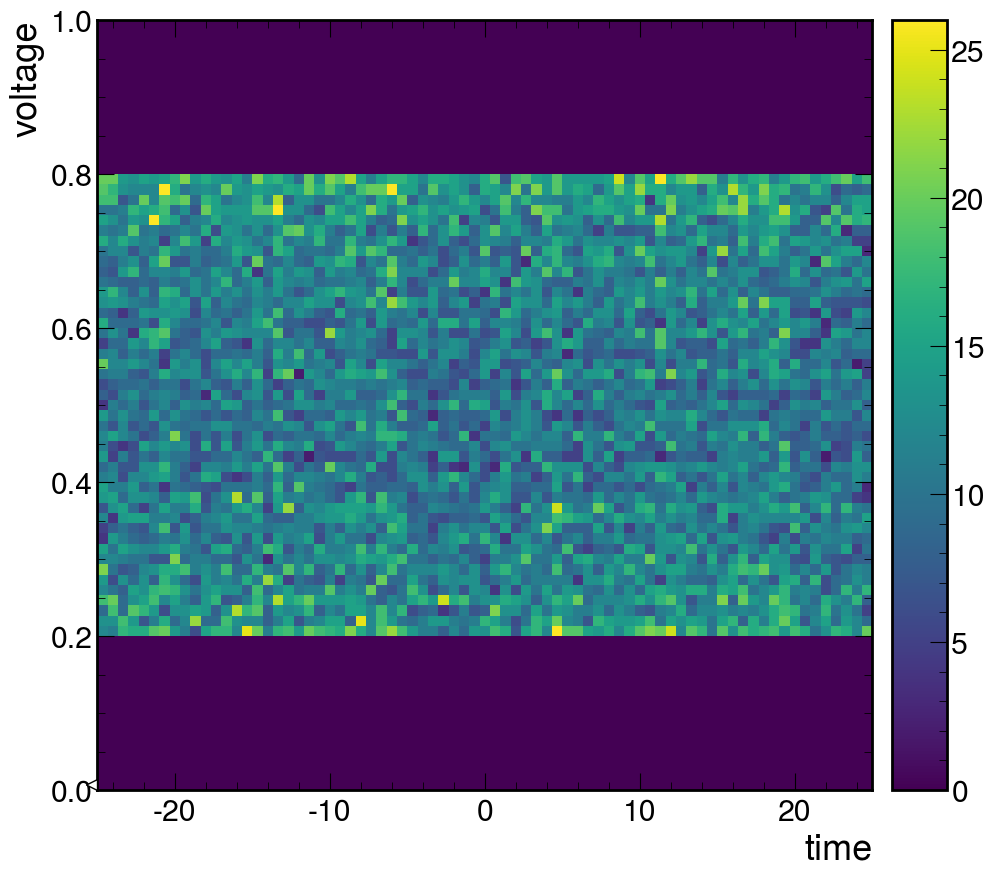

In [34]:

#heatmap
mask = ((0.2 <= clock) & (clock <= 0.8)) & (np.diff(clock, append=np.inf) < 0) #& ((-12.5 <= time) & (time <= 12.5))
hist_2d = hist.Hist(
    hist.axis.Regular(75,-25,25, name='time'),
    hist.axis.Regular(75,0,1, name='voltage'),
).fill(ak.flatten(time[mask]), ak.flatten(clock[mask]))

hep.hist2dplot(hist_2d)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f82e7e4e960>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f82e7d05a30>, text=[])

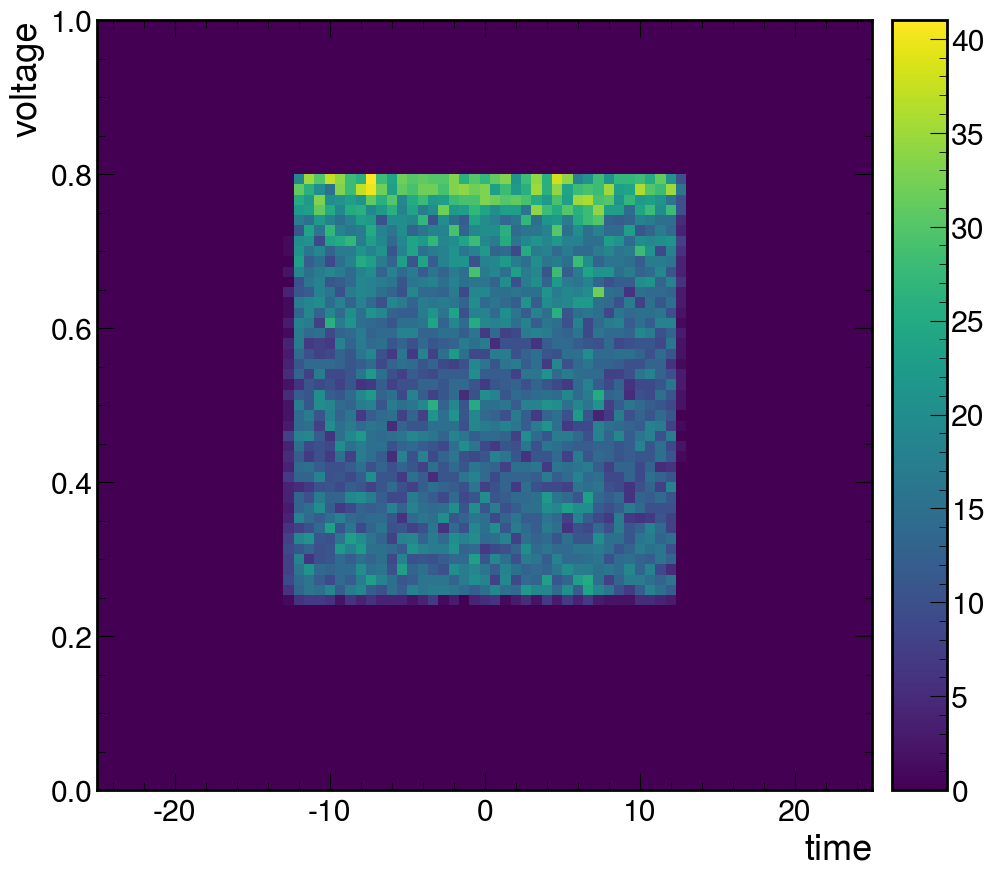

In [35]:
mask = ((0.2 <= clock) & (clock <= 0.8)) #& (np.diff(clock, append=np.inf) < 0)

hist_2d = hist.Hist(
    hist.axis.Regular(75,-25,25, name='time'),
    hist.axis.Regular(75,0,1, name='voltage'),
).fill(ak.flatten(rtime), ak.flatten(rclock))

hep.hist2dplot(hist_2d)